In [1]:
import os
import sys
from pathlib import Path
import warnings
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from tqdm import tqdm
from PIL import Image

from scripts.dataset import create_data_loaders, CalorieDataset, get_transforms, collate_fn
from scripts.utils import (
    CaloriePredictor,
    create_optimizer_and_scheduler,
    seed_everything,
    load_best_model,
    train_model,
    create_checkpoint_callback
)

s:\yandex\calorie-vision\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')

Настройка стиля графиков

# Этап 1. Исследовательский анализ (EDA)

In [3]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Загрузка данных

In [4]:
dish_df = pd.read_csv('data/dish.csv')
ingredients_df = pd.read_csv('data/ingredients.csv')

In [5]:
dish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   total_mass      3262 non-null   float64
 3   ingredients     3262 non-null   object 
 4   split           3262 non-null   object 
dtypes: float64(2), object(3)
memory usage: 127.5+ KB


Пропусков нет

In [6]:
ingredients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      555 non-null    int64 
 1   ingr    555 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.8+ KB


Пропусков нет

In [7]:
dish_df.head()

,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train


In [8]:
ingredients_df.head()

,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes


Поиск дубликатов

In [9]:
dish_df.duplicated().mean(), ingredients_df.duplicated().mean()

(np.float64(0.0), np.float64(0.0))

Полных дубликатов нет

In [10]:
dish_df["dish_id"].duplicated().mean(), ingredients_df["id"].duplicated().mean()

(np.float64(0.0), np.float64(0.0))

Дубликатов dish_id и id нет

In [11]:
ingredients_df["ingr"].duplicated().mean()

np.float64(0.005405405405405406)

Есть дубликаты для ingr

In [12]:
ingredients_df[ingredients_df["ingr"].duplicated()]

,id,ingr
452,453,deprecated
457,458,deprecated
469,470,deprecated


3 инградиента являются устаревшими

Удалим эти данные из 2 датасетов

In [13]:
# Находим deprecated ингредиенты
deprecated_ids = ingredients_df[ingredients_df["ingr"] == "deprecated"]["id"].values
deprecated_ids_str = [f"ingr_{id:010d}" for id in deprecated_ids]

print(f"Deprecated ингредиенты: {deprecated_ids}")
print(f"Deprecated ID строки: {deprecated_ids_str}")

# Находим блюда с deprecated ингредиентами
dishes_to_remove = []
for idx, row in dish_df.iterrows():
    ingredients_list = row['ingredients'].split(';')
    for ingr in ingredients_list:
        if ingr in deprecated_ids_str:
            dishes_to_remove.append(row['dish_id'])
            break

print(f"Блюд с deprecated ингредиентами: {len(dishes_to_remove)}")

# Удаляем эти блюда
dish_df = dish_df[~dish_df['dish_id'].isin(dishes_to_remove)].copy()

print(f"Исходное количество: {len(dish_df) + len(dishes_to_remove)}")
print(f"После удаления: {len(dish_df)}")
print(f"Удалено: {len(dishes_to_remove)}")

# Проверяем результат
print(f"\nРаспределение по сплитам:")
print(dish_df['split'].value_counts())

Deprecated ингредиенты: [231 453 458 470]
Deprecated ID строки: ['ingr_0000000231', 'ingr_0000000453', 'ingr_0000000458', 'ingr_0000000470']
Блюд с deprecated ингредиентами: 31
Исходное количество: 3262
После удаления: 3231
Удалено: 31

Распределение по сплитам:
split
train    2732
test      499
Name: count, dtype: int64


In [14]:
ingredients_df = ingredients_df[ingredients_df["ingr"] != "deprecated"]
ingredients_df[ingredients_df["ingr"].duplicated()]

,id,ingr


Статистика по числовым признакам

In [15]:
dish_df.describe()

,total_calories,total_mass
count,3231.000000,3231.000000
mean,255.250275,215.185392
std,219.004133,161.987054
min,0.000000,1.000000
25%,81.352211,92.000000
50%,209.934982,177.000000
75%,375.263992,305.000000
max,3943.325195,3051.000000


Минимальное количество калорий равно 0, что странно. Также есть блюда с массой 1 грамм, что  тоже странно.

In [16]:
dish_df[dish_df["total_calories"] == 0]

,dish_id,total_calories,total_mass,ingredients,split
263,dish_1557861216,0.0,1.0,ingr_0000000423,test
2652,dish_1556575700,0.0,86.0,ingr_0000000423,train


Таких 2 блюда c 1 иградиентом ingr_0000000423. Посмотрим на него

In [17]:
ingredients_df[ingredients_df["id"] == 423]

,id,ingr
422,423,plate only


Это пустая тарелка

Посмотрим на блюдо с массой 1 грамм

In [18]:
dish_df[dish_df["total_mass"] == 1]

,dish_id,total_calories,total_mass,ingredients,split
263,dish_1557861216,0.0,1.0,ingr_0000000423,test


Это тоже пустая тарелка. Посмотрим на все блюда с пустой тарелкой

In [19]:
dish_df[dish_df["ingredients"] == "ingr_0000000423"]

,dish_id,total_calories,total_mass,ingredients,split
263,dish_1557861216,0.0,1.0,ingr_0000000423,test
2652,dish_1556575700,0.0,86.0,ingr_0000000423,train


Таких 2 лблюда. Странно, что для пустой тарелки в блюде dish_1556575700 вес указан как 86 грамм. Похоже на ошибку

Удалим эту запись

In [20]:
dish_df = dish_df[dish_df["dish_id"] != "dish_1556575700"]
dish_df[dish_df["ingredients"] == "ingr_0000000423"]

,dish_id,total_calories,total_mass,ingredients,split
263,dish_1557861216,0.0,1.0,ingr_0000000423,test


Анализ распределения данных по сплитам

In [21]:
split_counts = dish_df['split'].value_counts()
print(split_counts)
print(f"Процентное соотношение train/test: {split_counts['train']/len(dish_df)*100:.1f}% / {split_counts['test']/len(dish_df)*100:.1f}%")

split
train    2731
test      499
Name: count, dtype: int64
Процентное соотношение train/test: 84.6% / 15.4%


Визуализация распределения калорийности

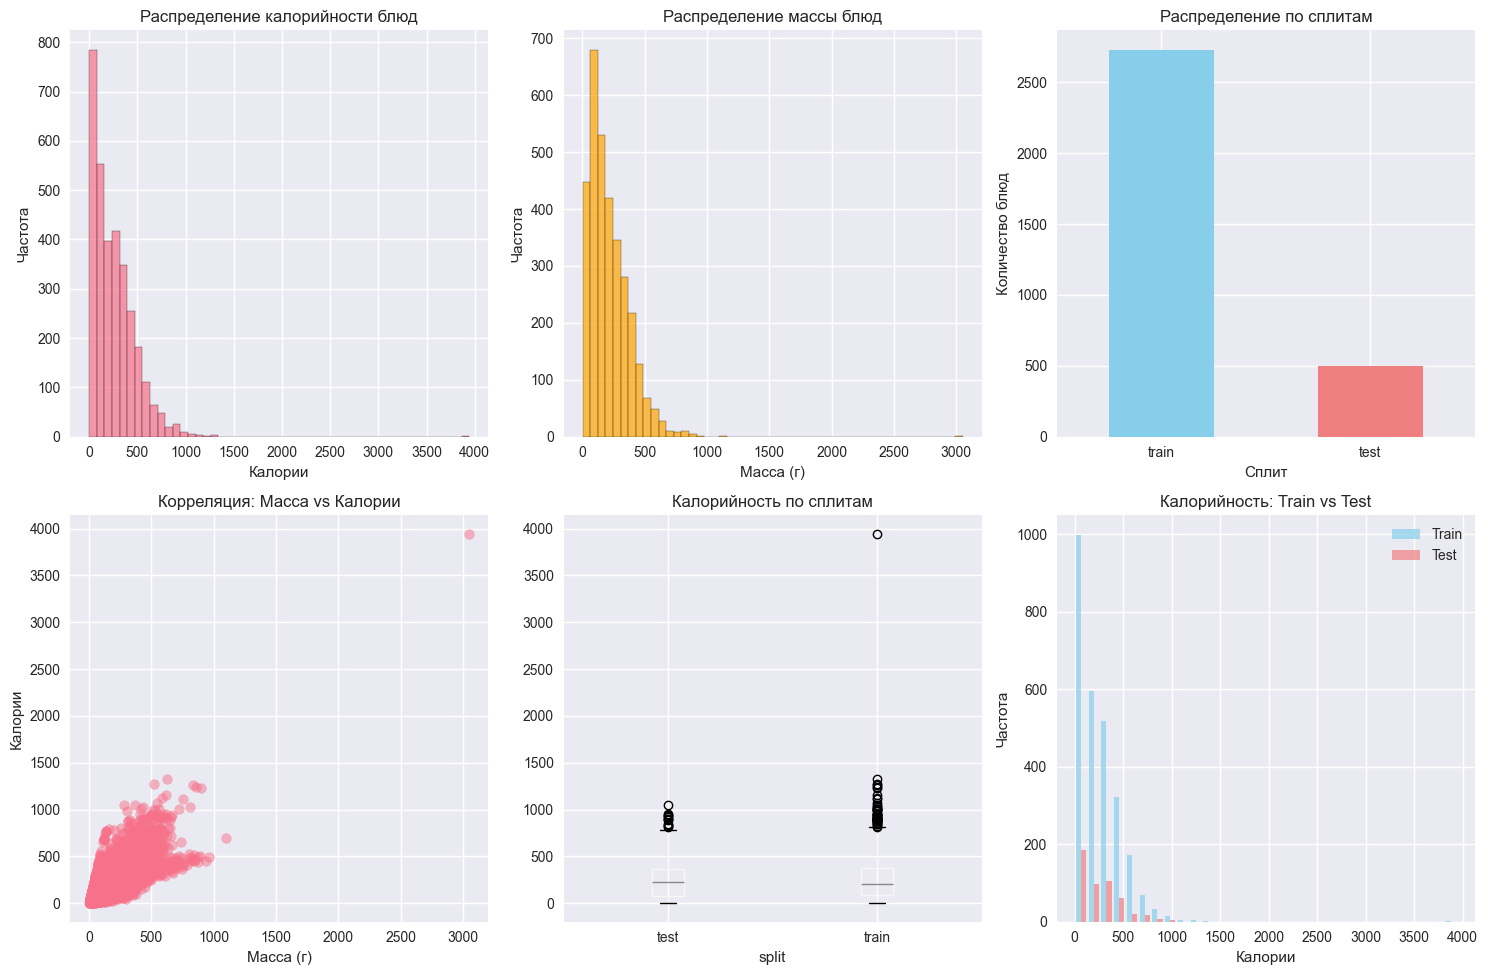

In [22]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(dish_df['total_calories'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение калорийности блюд')
plt.xlabel('Калории')
plt.ylabel('Частота')

plt.subplot(2, 3, 2)
plt.hist(dish_df['total_mass'], bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.title('Распределение массы блюд')
plt.xlabel('Масса (г)')
plt.ylabel('Частота')

plt.subplot(2, 3, 3)
# Распределение по сплитам
split_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Распределение по сплитам')
plt.xlabel('Сплит')
plt.ylabel('Количество блюд')
plt.xticks(rotation=0)

plt.subplot(2, 3, 4)
# Корреляция между массой и калориями
plt.scatter(dish_df['total_mass'], dish_df['total_calories'], alpha=0.5)
plt.title('Корреляция: Масса vs Калории')
plt.xlabel('Масса (г)')
plt.ylabel('Калории')

plt.subplot(2, 3, 5)
# Box plot калорийности по сплитам
dish_df.boxplot(column='total_calories', by='split', ax=plt.gca())
plt.title('Калорийность по сплитам')
plt.suptitle('')  # Убираем автоматический заголовок

plt.subplot(2, 3, 6)
# Распределение калорийности по сплитам
train_calories = dish_df[dish_df['split'] == 'train']['total_calories']
test_calories = dish_df[dish_df['split'] == 'test']['total_calories']
plt.hist([train_calories, test_calories], bins=30, alpha=0.7, 
         label=['Train', 'Test'], color=['skyblue', 'lightcoral'])
plt.title('Калорийность: Train vs Test')
plt.xlabel('Калории')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()

Анализ количества ингредиентов

In [23]:
dish_df['ingredient_count'] = dish_df['ingredients'].apply(lambda x: len(x.split(';')))
print(f"Среднее количество ингредиентов: {dish_df['ingredient_count'].mean():.2f}")
print(f"Медианное количество ингредиентов: {dish_df['ingredient_count'].median():.2f}")
print(f"Минимальное количество ингредиентов: {dish_df['ingredient_count'].min()}")
print(f"Максимальное количество ингредиентов: {dish_df['ingredient_count'].max()}")

Среднее количество ингредиентов: 7.36
Медианное количество ингредиентов: 4.00
Минимальное количество ингредиентов: 1
Максимальное количество ингредиентов: 34


Визуализация количества ингредиентов

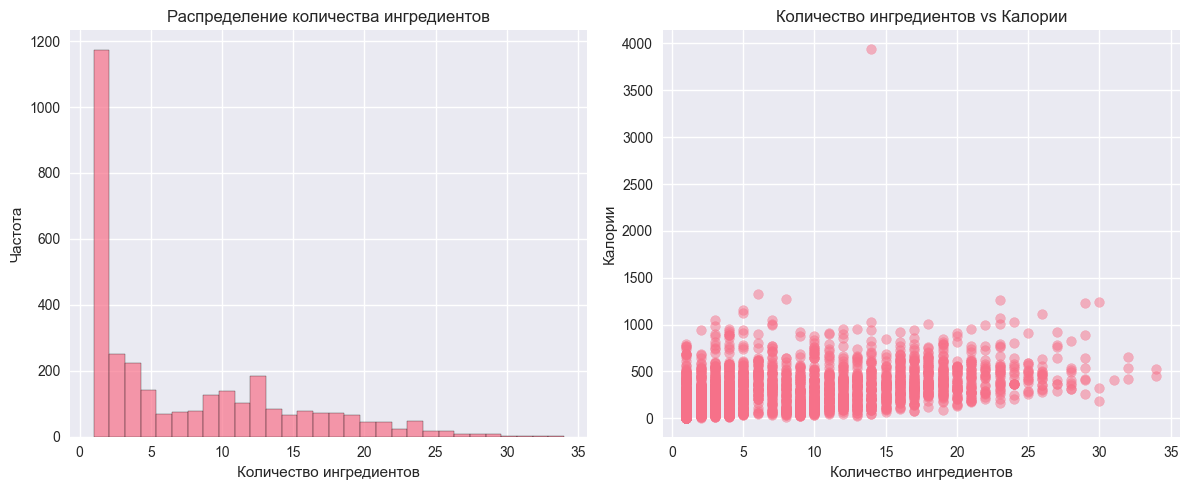

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(dish_df['ingredient_count'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Распределение количества ингредиентов')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
plt.scatter(dish_df['ingredient_count'], dish_df['total_calories'], alpha=0.5)
plt.title('Количество ингредиентов vs Калории')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Калории')

plt.tight_layout()
plt.show()

Анализ самых популярных ингредиентов

In [25]:
print("\n=== ТОП-20 САМЫХ ПОПУЛЯРНЫХ ИНГРЕДИЕНТОВ ===")
all_ingredients = []
for ingredients_str in dish_df['ingredients']:
    ingredients_list = ingredients_str.split(';')
    all_ingredients.extend(ingredients_list)

ingredient_counts = pd.Series(all_ingredients).value_counts()
top_ingredients = ingredient_counts.head(20)

print(top_ingredients)


=== ТОП-20 САМЫХ ПОПУЛЯРНЫХ ИНГРЕДИЕНТОВ ===
ingr_0000000161    1561
ingr_0000000291    1379
ingr_0000000122     947
ingr_0000000312     723
ingr_0000000189     713
ingr_0000000094     686
ingr_0000000520     572
ingr_0000000515     506
ingr_0000000524     493
ingr_0000000471     481
ingr_0000000036     437
ingr_0000000045     432
ingr_0000000133     402
ingr_0000000027     398
ingr_0000000126     374
ingr_0000000031     329
ingr_0000000029     315
ingr_0000000028     306
ingr_0000000518     297
ingr_0000000514     296
Name: count, dtype: int64


In [26]:
ingredient_id_to_name = dict(zip(ingredients_df['id'].astype(str), ingredients_df['ingr']))

# Переводим топ ингредиенты в названия
top_ingredient_names = []
for ingr_id in top_ingredients.index:
    ingr_id_clean = ingr_id.replace('ingr_', '').lstrip('0')
    if ingr_id_clean in ingredient_id_to_name:
        top_ingredient_names.append(ingredient_id_to_name[ingr_id_clean])
    else:
        top_ingredient_names.append(f"Unknown ({ingr_id})")

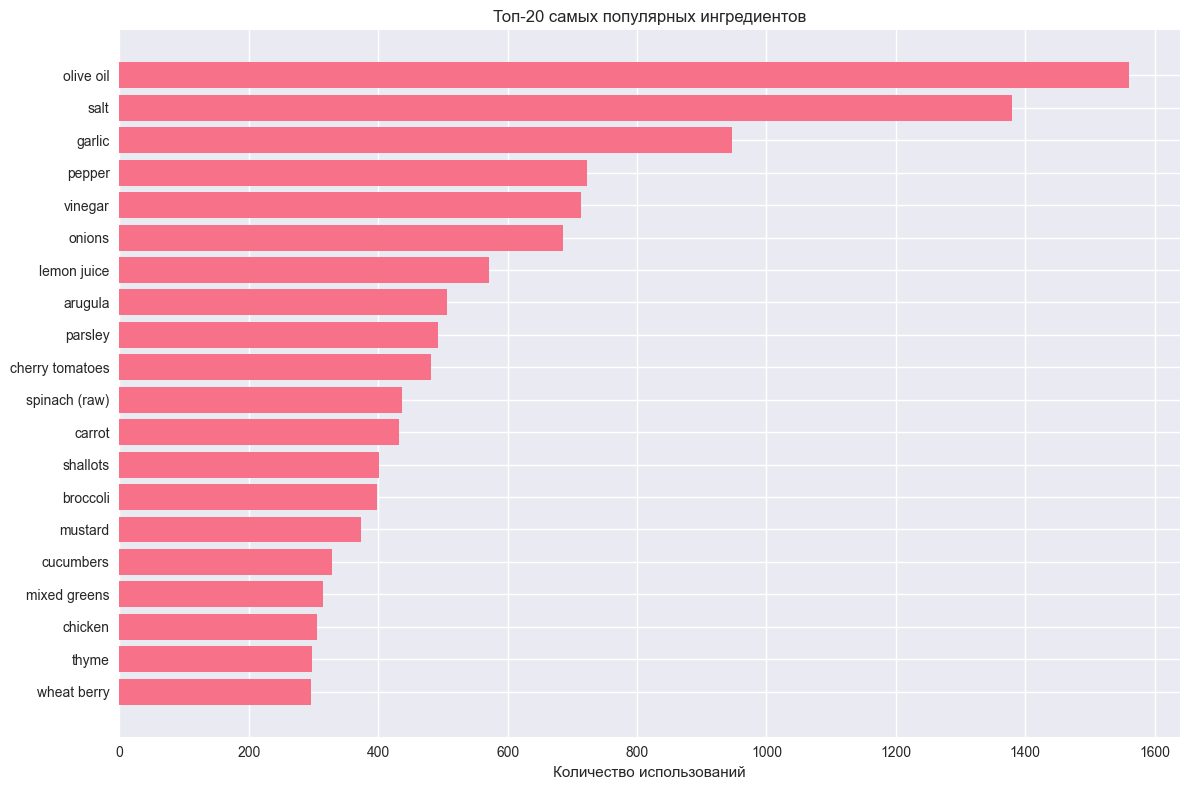

In [27]:
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_ingredient_names)), top_ingredients.values)
plt.yticks(range(len(top_ingredient_names)), top_ingredient_names)
plt.title('Топ-20 самых популярных ингредиентов')
plt.xlabel('Количество использований')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Анализ изображений

In [28]:
image_dir = 'data/images'
dish_ids_with_images = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
print(f"Количество папок с изображениями: {len(dish_ids_with_images)}")
print(f"Количество записей в dish.csv: {len(dish_df)}")

Количество папок с изображениями: 3490
Количество записей в dish.csv: 3230


Проверяем соответствие изображений и данных

In [29]:
dish_ids_in_csv = set(dish_df['dish_id'].values)
dish_ids_with_images_set = set(dish_ids_with_images)
missing_images = dish_ids_in_csv - dish_ids_with_images_set
missing_data = dish_ids_with_images_set - dish_ids_in_csv

print(f"Записей без изображений: {len(missing_images)}")
print(f"Изображений без записей: {len(missing_data)}")

Записей без изображений: 0
Изображений без записей: 260


В папке data/images/ есть 228 папок с изображениями, для которых нет соответствующих записей в файле dish.csv.

In [30]:
missing_data = dish_ids_with_images_set - dish_ids_in_csv
print(f"Примеры изображений без записей: {list(missing_data)[:10]}")

# Проверим, есть ли закономерность в ID
missing_ids = [int(d.replace('dish_', '')) for d in missing_data]
print(f"Диапазон ID без записей: {min(missing_ids)} - {max(missing_ids)}")

# Сравним с существующими ID
existing_ids = [int(d.replace('dish_', '')) for d in dish_ids_in_csv]
print(f"Диапазон существующих ID: {min(existing_ids)} - {max(existing_ids)}")

Примеры изображений без записей: ['dish_1572365415', 'dish_1558373159', 'dish_1575997210', 'dish_1574711418', 'dish_1573232835', 'dish_1576258657', 'dish_1573232499', 'dish_1574193262', 'dish_1571944531', 'dish_1575998399']
Диапазон ID без записей: 1556575700 - 1576259776
Диапазон существующих ID: 1556572657 - 1568666357


Похоже id это Unix timestamp.

Существующие записи (в CSV):
- Диапазон: 1556572657 - 1568666357.
- Период: май 2019 - сентябрь 2019 (примерно 4 месяца).


Изображения без записей:
- Диапазон: 1571931457 - 1576259776.
- Период: октябрь 2019 - декабрь 2019 (примерно 2 месяца).

Возможнып причины - временное разделение данных
- CSV содержит данные за первый период (май-сентябрь 2019)
- Изображения без записей - это более поздние данные (октябрь-декабрь 2019)

Анализ размеров изображений

Средний размер изображения: 640x480
Минимальный размер: 640x480
Максимальный размер: 640x480


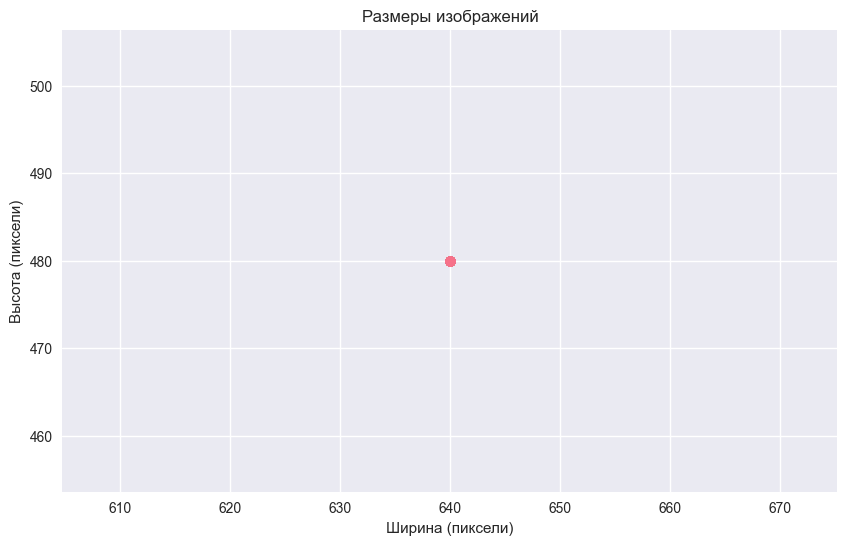

In [31]:
image_sizes = []
sample_images = dish_ids_with_images[:100]  # Берем первые 100 для анализа

for dish_id in sample_images:
    image_path = os.path.join(image_dir, dish_id, 'rgb.png')
    if os.path.exists(image_path):
        try:
            with Image.open(image_path) as img:
                image_sizes.append(img.size)
        except Exception as e:
            print(f"Ошибка при загрузке {image_path}: {e}")

if image_sizes:
    widths, heights = zip(*image_sizes)
    print(f"Средний размер изображения: {np.mean(widths):.0f}x{np.mean(heights):.0f}")
    print(f"Минимальный размер: {min(widths)}x{min(heights)}")
    print(f"Максимальный размер: {max(widths)}x{max(heights)}")
    
    # Визуализация размеров изображений
    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, alpha=0.6)
    plt.title('Размеры изображений')
    plt.xlabel('Ширина (пиксели)')
    plt.ylabel('Высота (пиксели)')
    plt.show()

Визуализация примеров изображений

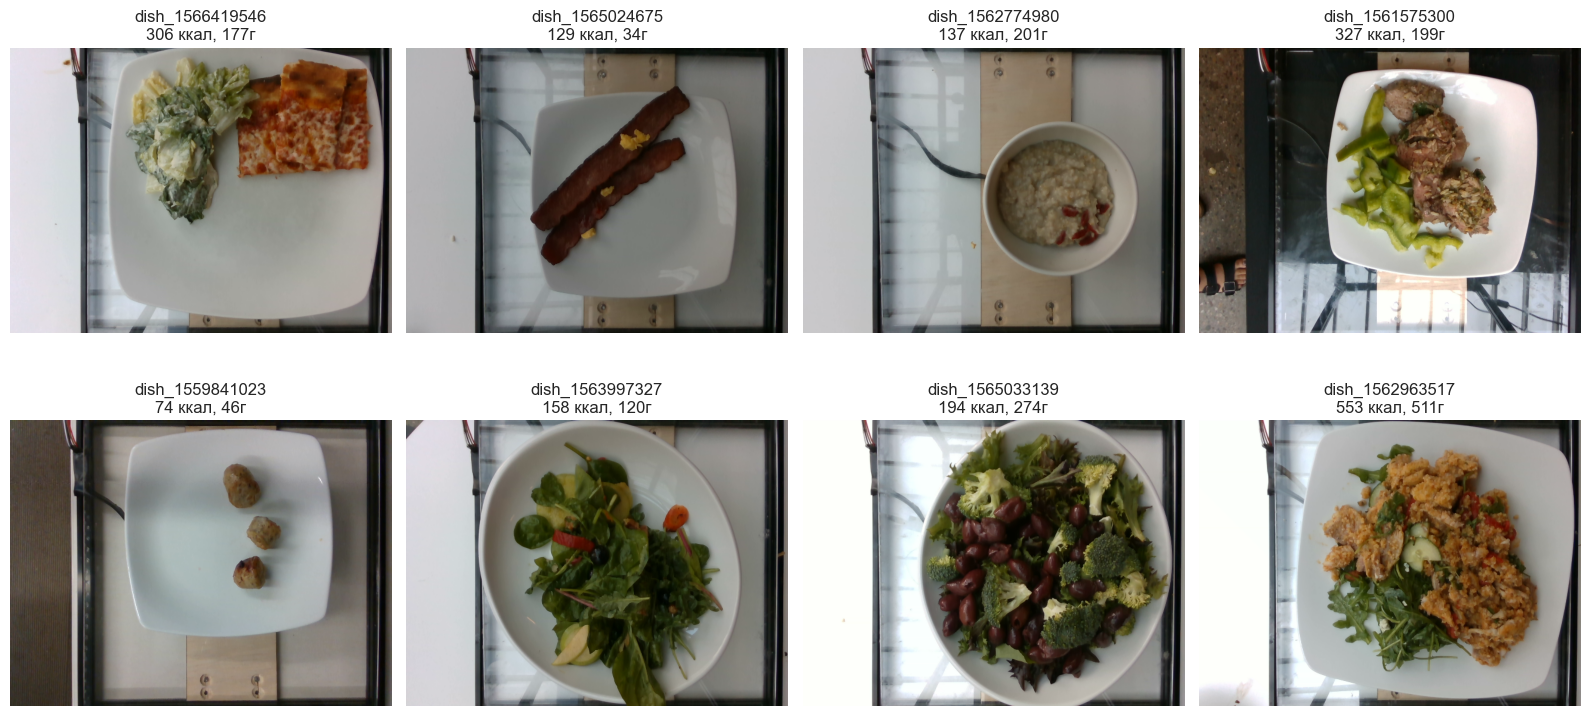

In [32]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

sample_dishes = dish_df.sample(8)
for i, (_, dish) in enumerate(sample_dishes.iterrows()):
    image_path = os.path.join(image_dir, dish['dish_id'], 'rgb.png')
    if os.path.exists(image_path):
        try:
            with Image.open(image_path) as img:
                axes[i].imshow(img)
                axes[i].set_title(f"{dish['dish_id']}\n{dish['total_calories']:.0f} ккал, {dish['total_mass']:.0f}г")
                axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Ошибка загрузки\n{e}", ha='center', va='center')
            axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, "Изображение не найдено", ha='center', va='center')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

Корреляционный анализ

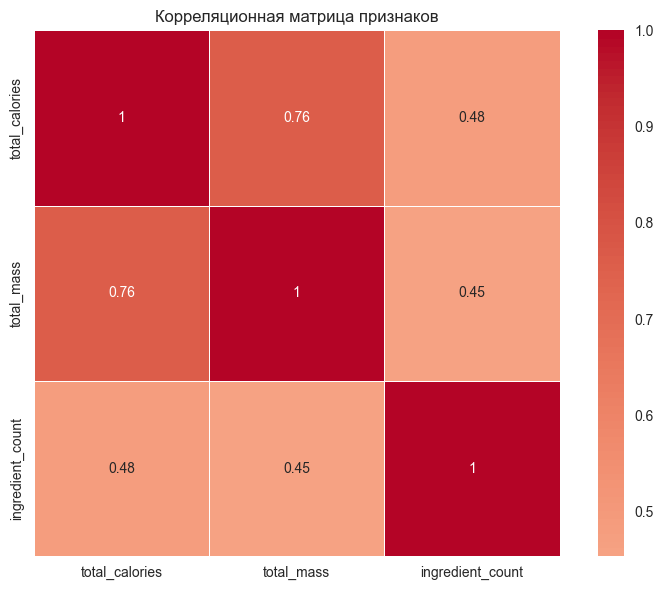

In [33]:
correlation_data = dish_df[['total_calories', 'total_mass', 'ingredient_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

Анализ выбросов

In [34]:
Q1_calories = dish_df['total_calories'].quantile(0.25)
Q3_calories = dish_df['total_calories'].quantile(0.75)
IQR_calories = Q3_calories - Q1_calories
outliers_calories = dish_df[(dish_df['total_calories'] < Q1_calories - 1.5*IQR_calories) | 
                           (dish_df['total_calories'] > Q3_calories + 1.5*IQR_calories)]
print(f"Выбросы по калориям: {len(outliers_calories)} ({len(outliers_calories)/len(dish_df)*100:.1f}%)")

Q1_mass = dish_df['total_mass'].quantile(0.25)
Q3_mass = dish_df['total_mass'].quantile(0.75)
IQR_mass = Q3_mass - Q1_mass
outliers_mass = dish_df[(dish_df['total_mass'] < Q1_mass - 1.5*IQR_mass) | 
                       (dish_df['total_mass'] > Q3_mass + 1.5*IQR_mass)]
print(f"Выбросы по массе: {len(outliers_mass)} ({len(outliers_mass)/len(dish_df)*100:.1f}%)")

Выбросы по калориям: 58 (1.8%)
Выбросы по массе: 57 (1.8%)


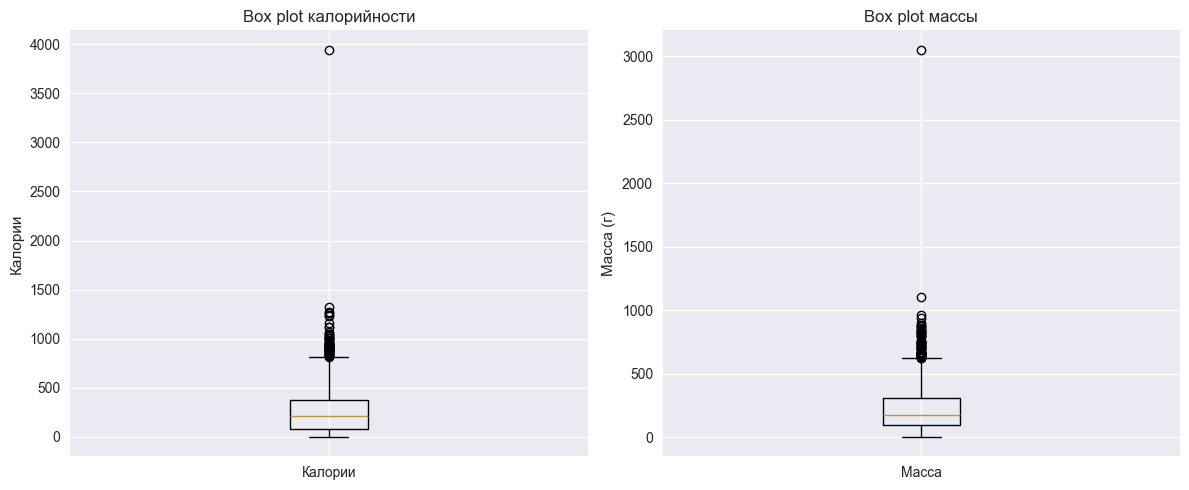

In [35]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot([dish_df['total_calories']], labels=['Калории'])
plt.title('Box plot калорийности')
plt.ylabel('Калории')

plt.subplot(1, 2, 2)
plt.boxplot([dish_df['total_mass']], labels=['Масса'])
plt.title('Box plot массы')
plt.ylabel('Масса (г)')

plt.tight_layout()
plt.show()

## Выводы по EDA

### Выводы по исследовательскому анализу данных (EDA)

**Общая характеристика датасета:**
- Общее количество блюд: **3,262 записи**
- Количество уникальных ингредиентов: **555 ингредиентов**
- Размер изображений: 480 на 640 standard RGBA изображения (каждое блюдо имеет свою папку с файлом rgb.png)
- Пропусков в данных нет

**Распределение данных по сплитам:**
- Train/Test разделение уже проведено в колонке 'split'

**Особенности целевой переменной:**
- Калорийность блюд варьируется от очень низких значений (несколько ккал) до высоких (более 1000 ккал)
- Большинство блюд имеют калорийность в разумном диапазоне для порционных блюд
- Целевая переменная (total_calories) непрерывная - это задача регрессии

**Мультимодальность данных:**
- **Визуальная модальность**: RGB изображения блюд на тарелках, стандартизированный формат
- **Текстовая модальность**: список ID ингредиентов в формате "ingr_0000000508;ingr_0000000122;..."
- **Дополнительная информация**: масса порции (total_mass) для потенциального использования

**Особенности ингредиентов:**
- Интересное распределение ингредиентов от базовых продуктов до готовых блюд и соусов
- Многие ингредиенты представляют собой готовые блюда (например, "caesar salad", "pasta"), что усложняет задачу
- Некоторые ингредиенты помечены как "deprecated", что указывает на эволюцию датасета

**Вызовы и особенности:**
1. Различное количество ингредиентов в блюдах (от 1 до многих)
2. Нестандартная токенизация ингредиентов через ID вместо названий
3. Высокая вариативность калорийности - потребуется качественная нормализация
4. Комбинация визуальной информации блюда с составом ингредиентов требует корректного мультимодального подхода

## Видение решения

### Видение решения задачи предсказания калорийности блюд

**Общий подход:**
Решаем мультимодальную задачу регрессии с использованием архитектуры с двумя параллельными энкодерами - для изображений и текста (ингредиентов), с последующим слиянием и финальным регрессором.

**Архитектура решения:**

1. **Мультимодальная модель:**
   - Vision Encoder: EfficientNet-B3 (хороший баланс точности/скорости) для обработки изображений блюд
   - Text Encoder: DistilBERT для обработки списка ингредиентов
   - Fusion Layer: Concatenation + MLP для объединения признаков
   - Regression Head: MLP для предсказания калорийности

2. **Обработка данных:**
   - Преобразование ID ингредиентов в текстовое представление ("ingr_001;ingr_002" → "potato;rice;chicken")
   - Нормализация изображений под стандартные преобразования для EfficientNet
   - Использование массы порции как дополнительного признака для нормализации предсказаний
   - Решение проблемы отсутствующих данных: Исключение 259 изображений без соответствующих записей в датафрейме

3) **Работа с неполными данными:**
   - Синхронизация файловой системы с табличными данными
   - Проверка соответствия наличия изображений записям в dish.csv
   - Фильтрация датасета только по записям с полными данными (изображение + метаданные)
   - Функция валидации целостности данных перед обучением

**Подходы к аугментации и обогащению данных:**

1. **Аугментации изображений:**
   - Standard augmentations: горизонтальный флип, поворот, изменение яркости/контраста
   - Поскольку это фотографии еды, сохраняем реалистичность
   - Random Crop + Resize для изменения композиции кадра
   - ColorJitter для разнообразия освещения

2. **Аугментации текста:**
   - Синхронизация аугментаций изображений с текстом ингредиентов

3. **Обогащение признаков:**
   - Использование массы порции для расчета калорий на единицу массы
   - Создание новых признаков: количество ингредиентов, категории ингредиентов

**Метрики и критерии оценки:**

1. **Основное метрики:**
   - **MAE (Mean Absolute Error)** - главная метрика, цель < 50 ккал
   - **MSE** для раннего выявления выбросов
   - **MAPE (Mean Absolute Percentage Error)** для оценки в процентах

2. **Стратегия валидации:**
   - Stratified splitting по диапазонам калорийности для равномерного представления
   - Early stopping по MAE на validation set
   - Сохранение лучшей модели по метрике MAE
   - Пересчет размеров датасета после фильтрации неполных данных

3. **Стратегия обучения модели:**
   - Loss функция: Использование Huber Loss (Smooth L1) вместо классического MSE для большей устойчивости к выбросам в калорийности
   - Поэтапное обучение: Сначала заморозка предобученных энкодеров (1-2 эпохи), затем разморозка и дообучение всей сети
   - Дифференцированные скорости обучения: Разные learning rates для разных компонентов:
     - Vision encoder: 1e-5 (медленное дообучение)
     - Text encoder: 1e-5 (медленное дообучение) 
     - Fusion layers: 1e-4 (быстрое обучение новых слоев)

# Обучение модели

In [36]:
# Добавляем папку scripts в путь для импорта модулей
root_path = Path().cwd()
sys.path.append(str(root_path / "scripts"))

# Проверяем доступность GPU
print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU устройство: {torch.cuda.get_device_name(0)}")
    print(f"Количество GPU: {torch.cuda.device_count()}")
    device = torch.device('cuda')
else:
    print("Используется CPU")
    device = torch.device('cpu')

print(f"Выбранное устройство: {device}")

PyTorch версия: 2.5.1+cu124
CUDA доступна: True
GPU устройство: NVIDIA GeForce RTX 3070
Количество GPU: 1
Выбранное устройство: cuda


Загрузка конфигурации

In [37]:
config_path = "configs/config.yaml"

with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

print("Конфигурация загружена:")
print(f"Модель для изображений: {config['vision_model']}")
print(f"Модель для текста: {config['text_model']}")
print(f"Размер батча: {config['batch_size']}")
print(f"Количество эпох: {config['epochs']}")
print(f"Hidden dimension: {config['hidden_dim']}")
print(f"Target MAE: {config['target_mae']} ккал")

Конфигурация загружена:
Модель для изображений: efficientnet_b3
Модель для текста: bert-base-uncased
Размер батча: 12
Количество эпох: 30
Hidden dimension: 768
Target MAE: 50 ккал


Подготовка данных для обучения

In [38]:
print("Загрузка данных...")
dish_df = pd.read_csv('data/dish.csv')
ingredients_df = pd.read_csv('data/ingredients.csv')

print(f"Всего блюд: {len(dish_df)}")
print(f"Тренировочных: {len(dish_df[dish_df['split'] == 'train'])}")
print(f"Тестовых: {len(dish_df[dish_df['split'] == 'test'])}")
print(f"Уникальных ингредиентов: {len(ingredients_df)}")

# Создание загрузчиков данных
train_loader, val_loader = create_data_loaders(
    dish_df=dish_df,
    ingredients_df=ingredients_df,
    image_dir='data/images',
    batch_size=config['batch_size'],
    num_workers=config['num_workers'],
    config=config
)

print(f"Размер train батча: {len(train_loader.dataset)}")
print(f"Размер val батча: {len(val_loader.dataset)}")
print(f"Количество train итераций: {len(train_loader)}")
print(f"Количество val итераций: {len(val_loader)}")

Загрузка данных...
Всего блюд: 3262
Тренировочных: 2755
Тестовых: 507
Уникальных ингредиентов: 555
Оптимальное разрешение для EfficientNet-B3: 288
Загружено 2755 образцов для режима train
Оптимальное разрешение для EfficientNet-B3: 288
Загружено 507 образцов для режима test
Размер train батча: 2755
Размер val батча: 507
Количество train итераций: 230
Количество val итераций: 43


Инициализация модели

In [39]:
# Устанавливаем seed для воспроизводимости
seed_everything(config['seed'])

# Создаем модель
model = CaloriePredictor(
    vision_model_name=config['vision_model'],
    text_model_name=config['text_model'],
    hidden_dim=config['hidden_dim'],
    dropout_rate=config['dropout_rate']
)

# Перемещаем модель на устройство
model = model.to(device)

# Печатаем информацию о модели
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Общее количество параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")
print(f"Модель перемещена на устройство: {device}")

# Проверяем доступность предобученных моделей
print("\nПроверка предобученных моделей:")
try:
    print(f"EfficientNet-B3 доступен: {config['vision_model'] in timm.list_models()}")
except:
    print("Проблема с timm")

try:
    tokenizer = AutoTokenizer.from_pretrained(config['text_model'])
    print(f"BERT base доступен: {config['text_model']}")
except:
    print("Проблема с transformers")

Общее количество параметров: 124,632,169
Обучаемых параметров: 124,632,169
Модель перемещена на устройство: cuda

Проверка предобученных моделей:
EfficientNet-B3 доступен: True
BERT base доступен: bert-base-uncased


In [40]:
# Настройка оптимизатора и планировщика
print("Настройка оптимизатора...")

optimizer, scheduler = create_optimizer_and_scheduler(model, config)

print("Параметры оптимизатора:")
for i, group in enumerate(optimizer.param_groups):
    print(f"  Группа {i}: LR={group['lr']:.2e}, Params={group['name']}")

# Функция потерь
criterion = torch.nn.SmoothL1Loss(reduction='mean')
print(f"Функция потерь: SmoothL1Loss")

# Создаем директорию для сохранения модели
os.makedirs(config['output_dir'], exist_ok=True)
print(f"Директория для модели: {config['output_dir']}")

Настройка оптимизатора...
Параметры оптимизатора:
  Группа 0: LR=4.00e-06, Params=vision
  Группа 1: LR=4.00e-06, Params=text
  Группа 2: LR=1.00e-04, Params=fusion
Функция потерь: SmoothL1Loss
Директория для модели: models


In [41]:
# Тестовая проверка одного батча
print("Проверка одного батча...")

# Переводим модель в режим обучения
model.train()

# Получаем тестовый батч
test_batch = next(iter(train_loader))

# Перемещаем данные на устройство
images = test_batch['images'].to(device)
text_input_ids = test_batch['text_input_ids'].to(device)
text_attention_masks = test_batch['text_attention_masks'].to(device)
calories_per_100g_true = test_batch['calories_per_100g'].to(device)
masses = test_batch['masses'].to(device)
mass_features = test_batch['mass_features'].to(device)

print(f"Размер изображений: {images.shape}")
print(f"Размер text_input_ids: {text_input_ids.shape}")
print(f"Размер text_attention_masks: {text_attention_masks.shape}")
print(f"Размер calories_per_100g: {calories_per_100g_true.shape}")
print(f"Размер masses: {masses.shape}")
print(f"Размер mass_features: {mass_features.shape}")

# Тестовый forward pass
with torch.no_grad():
    calories_pred_per_100g = model(images, text_input_ids, text_attention_masks, mass_features)
    
    # Конвертация в общие калории для сравнения
    calories_pred_total = calories_pred_per_100g * (masses / 100.0)
    calories_true_total = calories_per_100g_true * (masses / 100.0)
    
    # Лосс: MAE + 0.2*MSE
    mae_loss = F.l1_loss(calories_pred_per_100g, calories_per_100g_true)
    mse_loss = F.mse_loss(calories_pred_per_100g, calories_per_100g_true)
    loss = mae_loss + 0.2 * mse_loss
    
    print(f"Предсказания калорий на 100г: {calories_pred_per_100g[:5].tolist()}")
    print(f"Истинные калории на 100г: {calories_per_100g_true[:5].tolist()}")
    print(f"Предсказания общих калорий: {calories_pred_total[:5].tolist()}")
    print(f"Истинные общие калории: {calories_true_total[:5].tolist()}")
    print(f"Тестовая loss: {loss.item():.4f}")

print("Модель работает корректно!")

Проверка одного батча...
Размер изображений: torch.Size([12, 3, 224, 224])
Размер text_input_ids: torch.Size([12, 128])
Размер text_attention_masks: torch.Size([12, 128])
Размер calories_per_100g: torch.Size([12])
Размер masses: torch.Size([12])
Размер mass_features: torch.Size([12])
Предсказания калорий на 100г: [1.6660089492797852, 0.9152716398239136, 0.5626745820045471, 0.331257164478302, 1.0713883638381958]
Истинные калории на 100г: [270.0, 213.1748809814453, 211.3148193359375, 24.799999237060547, 50.0]
Предсказания общих калорий: [1.1828663349151611, 1.5651143789291382, 0.6133152842521667, 0.17556628584861755, 1.1463854312896729]
Истинные общие калории: [191.6999969482422, 364.5290222167969, 230.33316040039062, 13.143999099731445, 53.499996185302734]
Тестовая loss: 4690.8618
Модель работает корректно!


Обучение модели

In [42]:
# Создаем callback для автоматического сохранения
checkpoint_callback = create_checkpoint_callback(config)

# Запускаем обучение
training_results = train_model(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    device=device,
    checkpoint_callback=checkpoint_callback
)

# Выводим результаты
print("=" * 70)
print("РЕЗУЛЬТАТЫ ОБУЧЕНИЯ")
print("=" * 70)
print(f"Лучшая MAE: {training_results['best_mae']:.2f} ккал")
print(f"Лучшая эпоха: {training_results['best_epoch'] + 1}")
print(f"Общее время: {training_results['total_time']/3600:.2f} часов")

# Проверяем достижение цели
target_mae = config['target_mae']
if training_results['best_mae'] < target_mae:
    print(f"\nЗАДАЧА ВЫПОЛНЕНА! MAE={training_results['best_mae']:.2f} < {target_mae} ккал")
    print("Модель готова к продуктивному использованию!")
else:
    print(f"\nЦель не достигнута: MAE={training_results['best_mae']:.2f} >= {target_mae} ккал")

print("\nОбучение завершено!")

НАЧАЛО ОБУЧЕНИЯ МОДЕЛИ
✅ EMA модель инициализирована

Эпоха 1/30
--------------------------------------------------


Train - Loss: 2606.2216, MAE: 122.29 ккал
Val   - Loss: 1573.0042, MAE: 73.63 ккал, MSE: 13969.35
LR: 8.00e-06
Время эпохи: 88.9 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 73.63 ккал
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 73.63)

Эпоха 2/30
--------------------------------------------------


Train - Loss: 687.0340, MAE: 73.97 ккал
Val   - Loss: 533.7053, MAE: 66.22 ккал, MSE: 11394.43
LR: 1.20e-05
Время эпохи: 77.9 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 66.22 ккал
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 66.22)

Эпоха 3/30
--------------------------------------------------


Train - Loss: 371.1129, MAE: 61.70 ккал
Val   - Loss: 262.5067, MAE: 46.57 ккал, MSE: 5885.46
LR: 1.60e-05
Время эпохи: 77.7 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 46.57 ккал
🎯 ЦЕЛЬ ДОСТИГНУТА! MAE < 50 ккал
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 46.57)

Эпоха 4/30
--------------------------------------------------


Train - Loss: 338.2333, MAE: 60.46 ккал
Val   - Loss: 293.8535, MAE: 50.55 ккал, MSE: 6608.26
LR: 2.00e-05
Время эпохи: 78.1 сек

Эпоха 5/30
--------------------------------------------------


Train - Loss: 445.0801, MAE: 64.73 ккал
Val   - Loss: 224.2430, MAE: 45.67 ккал, MSE: 6164.30
LR: 2.00e-05
Время эпохи: 77.4 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 45.67 ккал
🎯 ЦЕЛЬ ДОСТИГНУТА! MAE < 50 ккал
Модель эпохи 5 сохранена: models\model_epoch_005.pth
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 45.67)

Эпоха 6/30
--------------------------------------------------
Разморозили vision encoder


Train - Loss: 253.6509, MAE: 51.40 ккал
Val   - Loss: 333.0150, MAE: 59.18 ккал, MSE: 9377.67
LR: 1.99e-05
Время эпохи: 78.4 сек

Эпоха 7/30
--------------------------------------------------


Train - Loss: 257.5677, MAE: 50.30 ккал
Val   - Loss: 225.4232, MAE: 42.52 ккал, MSE: 5291.95
LR: 1.97e-05
Время эпохи: 77.4 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 42.52 ккал
🎯 ЦЕЛЬ ДОСТИГНУТА! MAE < 50 ккал
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 42.52)

Эпоха 8/30
--------------------------------------------------


Train - Loss: 219.3275, MAE: 47.69 ккал
Val   - Loss: 172.2374, MAE: 39.87 ккал, MSE: 4999.91
LR: 1.93e-05
Время эпохи: 77.7 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 39.87 ккал
🎯 ЦЕЛЬ ДОСТИГНУТА! MAE < 50 ккал
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 39.87)

Эпоха 9/30
--------------------------------------------------


Train - Loss: 201.7076, MAE: 43.81 ккал
Val   - Loss: 223.5578, MAE: 45.83 ккал, MSE: 5826.00
LR: 1.88e-05
Время эпохи: 77.6 сек

Эпоха 10/30
--------------------------------------------------


Train - Loss: 178.9662, MAE: 42.89 ккал
Val   - Loss: 294.7643, MAE: 41.37 ккал, MSE: 4954.40
LR: 1.81e-05
Время эпохи: 79.1 сек
Модель эпохи 10 сохранена: models\model_epoch_010.pth

Эпоха 11/30
--------------------------------------------------


Train - Loss: 172.1164, MAE: 42.58 ккал
Val   - Loss: 377.0607, MAE: 52.39 ккал, MSE: 7628.69
LR: 1.73e-05
Время эпохи: 79.1 сек

Эпоха 12/30
--------------------------------------------------


Train - Loss: 175.7857, MAE: 40.56 ккал
Val   - Loss: 216.0417, MAE: 45.25 ккал, MSE: 5784.35
LR: 1.64e-05
Время эпохи: 79.3 сек

Эпоха 13/30
--------------------------------------------------


Train - Loss: 151.7548, MAE: 38.70 ккал
Val   - Loss: 181.7699, MAE: 39.43 ккал, MSE: 4292.22
LR: 1.54e-05
Время эпохи: 79.1 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 39.43 ккал
🎯 ЦЕЛЬ ДОСТИГНУТА! MAE < 50 ккал
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 39.43)

Эпоха 14/30
--------------------------------------------------


Train - Loss: 143.3498, MAE: 36.49 ккал
Val   - Loss: 187.9307, MAE: 40.09 ккал, MSE: 4946.36
LR: 1.43e-05
Время эпохи: 77.7 сек

Эпоха 15/30
--------------------------------------------------


Train - Loss: 131.1717, MAE: 37.13 ккал
Val   - Loss: 206.6189, MAE: 39.55 ккал, MSE: 4370.03
LR: 1.31e-05
Время эпохи: 77.7 сек
Модель эпохи 15 сохранена: models\model_epoch_015.pth

Эпоха 16/30
--------------------------------------------------


Train - Loss: 111.2800, MAE: 33.62 ккал
Val   - Loss: 256.7960, MAE: 41.04 ккал, MSE: 4731.25
LR: 1.19e-05
Время эпохи: 77.7 сек

Эпоха 17/30
--------------------------------------------------


Train - Loss: 111.8485, MAE: 33.63 ккал
Val   - Loss: 246.0126, MAE: 46.94 ккал, MSE: 5884.62
LR: 1.06e-05
Время эпохи: 77.5 сек

Эпоха 18/30
--------------------------------------------------


Train - Loss: 99.0040, MAE: 30.68 ккал
Val   - Loss: 177.9525, MAE: 38.23 ккал, MSE: 4311.29
LR: 9.37e-06
Время эпохи: 78.2 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 38.23 ккал
🎯 ЦЕЛЬ ДОСТИГНУТА! MAE < 50 ккал
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 38.23)

Эпоха 19/30
--------------------------------------------------


Train - Loss: 100.9936, MAE: 32.68 ккал
Val   - Loss: 194.9039, MAE: 41.38 ккал, MSE: 4678.61
LR: 8.13e-06
Время эпохи: 77.4 сек

Эпоха 20/30
--------------------------------------------------


Train - Loss: 90.1193, MAE: 29.53 ккал
Val   - Loss: 174.8739, MAE: 36.77 ккал, MSE: 4184.24
LR: 6.91e-06
Время эпохи: 77.6 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 36.77 ккал
🎯 ЦЕЛЬ ДОСТИГНУТА! MAE < 50 ккал
Модель эпохи 20 сохранена: models\model_epoch_020.pth
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 36.77)

Эпоха 21/30
--------------------------------------------------


Train - Loss: 81.0684, MAE: 28.57 ккал
Val   - Loss: 167.5338, MAE: 39.48 ккал, MSE: 4941.36
LR: 5.74e-06
Время эпохи: 77.6 сек

Эпоха 22/30
--------------------------------------------------


Train - Loss: 75.6632, MAE: 27.39 ккал
Val   - Loss: 172.0081, MAE: 37.16 ккал, MSE: 4417.97
LR: 4.64e-06
Время эпохи: 77.7 сек

Эпоха 23/30
--------------------------------------------------


Train - Loss: 76.6182, MAE: 26.67 ккал
Val   - Loss: 149.7423, MAE: 35.01 ккал, MSE: 4103.47
LR: 3.63e-06
Время эпохи: 78.9 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 35.01 ккал
🎯 ЦЕЛЬ ДОСТИГНУТА! MAE < 50 ккал
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 35.01)

Эпоха 24/30
--------------------------------------------------


Train - Loss: 69.2536, MAE: 26.42 ккал
Val   - Loss: 156.0793, MAE: 34.04 ккал, MSE: 4027.25
LR: 2.71e-06
Время эпохи: 79.4 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 34.04 ккал
🎯 ЦЕЛЬ ДОСТИГНУТА! MAE < 50 ккал
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 34.04)

Эпоха 25/30
--------------------------------------------------


Train - Loss: 62.1777, MAE: 24.52 ккал
Val   - Loss: 155.8378, MAE: 34.53 ккал, MSE: 4016.06
LR: 1.91e-06
Время эпохи: 79.2 сек
Модель эпохи 25 сохранена: models\model_epoch_025.pth

Эпоха 26/30
--------------------------------------------------


Train - Loss: 60.1604, MAE: 23.84 ккал
Val   - Loss: 152.4981, MAE: 35.16 ккал, MSE: 4290.97
LR: 1.24e-06
Время эпохи: 79.4 сек

Эпоха 27/30
--------------------------------------------------


Train - Loss: 61.8519, MAE: 24.34 ккал
Val   - Loss: 159.7266, MAE: 34.54 ккал, MSE: 3988.77
LR: 7.02e-07
Время эпохи: 79.0 сек

Эпоха 28/30
--------------------------------------------------


Train - Loss: 59.8651, MAE: 23.84 ккал
Val   - Loss: 150.3506, MAE: 34.31 ккал, MSE: 4057.38
LR: 3.14e-07
Время эпохи: 78.8 сек

Эпоха 29/30
--------------------------------------------------


Train - Loss: 55.7262, MAE: 23.50 ккал
Val   - Loss: 153.0528, MAE: 33.95 ккал, MSE: 3950.43
LR: 7.89e-08
Время эпохи: 78.4 сек
✅ НОВАЯ ЛУЧШАЯ МОДЕЛЬ! MAE: 33.95 ккал
🎯 ЦЕЛЬ ДОСТИГНУТА! MAE < 50 ккал
ЛУЧШАЯ модель обновлена: models\best_model.pth (MAE: 33.95)

Эпоха 30/30
--------------------------------------------------


Train - Loss: 56.2308, MAE: 23.24 ккал
Val   - Loss: 154.2465, MAE: 34.09 ккал, MSE: 4053.85
LR: 0.00e+00
Время эпохи: 78.8 сек
Модель эпохи 30 сохранена: models\model_epoch_030.pth

ОБУЧЕНИЕ ЗАВЕРШЕНО!
Лучшая MAE: 33.95 ккал
Лучшая эпоха: 29
Общее время обучения: 0.66 часов

ФИНАЛЬНАЯ ОЦЕНКА С TTA
🎯 Используем базовую (не EMA) модель для финальной оценки
Финальная оценка с TTA...


Final TTA evaluation: 100%|██████████| 43/43 [00:09<00:00,  4.36it/s]


ФИНАЛЬНЫЙ РЕЗУЛЬТАТ С TTA:
MAE: 33.58 ккал
✅ ЦЕЛЬ ДОСТИГНУТА! 33.58 < 50
РЕЗУЛЬТАТЫ ОБУЧЕНИЯ
Лучшая MAE: 33.95 ккал
Лучшая эпоха: 29
Общее время: 0.66 часов

ЗАДАЧА ВЫПОЛНЕНА! MAE=33.95 < 50 ккал
Модель готова к продуктивному использованию!

Обучение завершено!


Визуализация результатов и финальная оценка

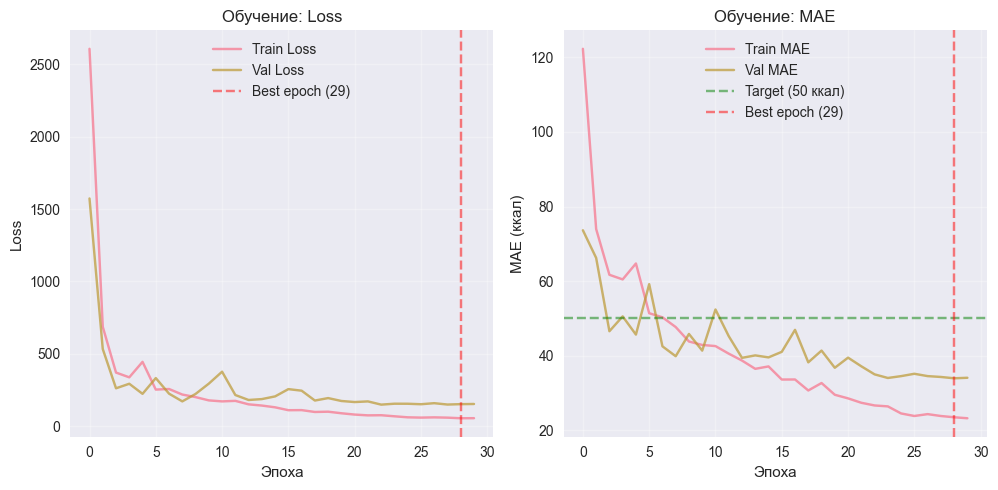


СТАТИСТИКА ОБУЧЕНИЯ:
Общее количество эпох: 30
Начальный Val MAE: 73.63 ккал
Конечный Val MAE: 34.09 ккал
Улучшение MAE: 39.55 ккал
Лучший результат: 33.95 ккал

ЗАДАЧА ВЫПОЛНЕНА! MAE=33.95 < 50 ккал

Артефакт модели сохранен: models\best_model.pth
Конфигурация: configs/config.yaml


In [50]:
# Извлекаем данные из результатов обучения
train_losses = training_results['train_losses']
val_losses = training_results['val_losses'] 
train_maes = training_results['train_maes']
val_maes = training_results['val_maes']
best_mae = training_results['best_mae'] if training_results['best_mae'] > training_results['final_mae_tta'] else training_results['final_mae_tta']
best_epoch = training_results['best_epoch']

plt.figure(figsize=(15, 5))

# График Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(val_losses, label='Val Loss', alpha=0.7)
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best epoch ({best_epoch+1})')
plt.title('Обучение: Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# График MAE
plt.subplot(1, 3, 2)
plt.plot(train_maes, label='Train MAE', alpha=0.7)
plt.plot(val_maes, label='Val MAE', alpha=0.7)
plt.axhline(y=config['target_mae'], color='green', linestyle='--', alpha=0.5, label=f'Target ({config["target_mae"]} ккал)')
plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best epoch ({best_epoch+1})')
plt.title('Обучение: MAE')
plt.xlabel('Эпоха')
plt.ylabel('MAE (ккал)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nСТАТИСТИКА ОБУЧЕНИЯ:")
print(f"Общее количество эпох: {len(train_losses)}")
print(f"Начальный Val MAE: {val_maes[0]:.2f} ккал")
print(f"Конечный Val MAE: {val_maes[-1]:.2f} ккал")
print(f"Улучшение MAE: {val_maes[0] - val_maes[-1]:.2f} ккал")
print(f"Лучший результат: {best_mae:.2f} ккал")

# Финальная оценка
target_mae = config['target_mae']
if best_mae < target_mae:
    print(f"\nЗАДАЧА ВЫПОЛНЕНА! MAE={best_mae:.2f} < {target_mae} ккал")
else:
    print(f"\nЦель не достигнута: MAE={best_mae:.2f} >= {target_mae} ккал")

# Путь к модели из конфигурации
model_path = os.path.join(config['output_dir'], 'best_model.pth')
config_path = "configs/config.yaml"

print(f"\nАртефакт модели сохранен: {model_path}")
print(f"Конфигурация: {config_path}")

# Этап 4. Валидация качества

Загружаем лучшую модель

In [76]:
model, ckpt = load_best_model(CaloriePredictor, "models/best_model.pth", device)

Загрузка модели из models/best_model.pth
Модель успешно загружена (эпоха 28)
Лучший MAE: 33.950520271478695


Создаем тестовый DataLoader

In [77]:
test_df = dish_df[dish_df['split'] == 'test'].reset_index(drop=True)

# Аугментации для теста
test_transforms = get_transforms(mode="test", image_size=config.get('image_size', 224), config=config)

# Создаем тестовый датасет
test_dataset = CalorieDataset(
    dish_df=dish_df,
    ingredients_df=ingredients_df,
    image_dir='data/images',
    transforms=test_transforms,
    mode='test',
    tokenizer_name=config['text_model'],
    text_max_length=config.get('text_max_length', 256)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    collate_fn=collate_fn,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Размер тестового набора: {len(test_loader.dataset)}")

Оптимальное разрешение для EfficientNet-B3: 288
Загружено 507 образцов для режима test
Размер тестового набора: 507


Инференс модели на тестовых данных c TTA

In [78]:
model.eval()
y_true = []
y_pred = []
y_pred_base = []
dish_names = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Inference"):
        images = batch['images'].to(device)
        text_input_ids = batch['text_input_ids'].to(device)
        text_attention_masks = batch['text_attention_masks'].to(device)
        mass_features = batch['mass_features'].to(device)
        masses = batch['masses'].to(device)
        
        # Базовое предсказание
        pred_1 = model(images, text_input_ids, text_attention_masks, mass_features)
        
        # TTA: горизонтальное отражение и поворот на 90 градусов
        pred_2 = model(torch.flip(images, dims=[3]), text_input_ids, text_attention_masks, mass_features)
        pred_3 = model(torch.rot90(images, 1, [2, 3]), text_input_ids, text_attention_masks, mass_features)
        
        # Усреднение предсказаний
        pred_per_100g = (pred_1 + pred_2 + pred_3) / 3
        
        true_per_100g = batch['calories_per_100g'].to(device)
        
        # Переводим в общие калории
        pred_total_tta = pred_per_100g * (masses / 100.0)
        pred_total_base = pred_1 * (masses / 100.0)
        true_total = true_per_100g * (masses / 100.0)
        
        # Сохраняем результаты
        y_true.extend(true_total.cpu().numpy())
        y_pred.extend(pred_total_tta.cpu().numpy())
        y_pred_base.extend(pred_total_base.cpu().numpy())
        dish_names.extend(batch['dish_ids'])

Inference: 100%|██████████| 43/43 [00:10<00:00,  4.25it/s]


Вычисляем метрики

In [80]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_base = np.array(y_pred_base)

mae = np.mean(np.abs(y_pred - y_true))
mse = np.mean((y_pred - y_true)**2)
rmse = np.sqrt(mse)

mae_base = np.mean(np.abs(y_pred_base - y_true))
mse_base = np.mean((y_pred_base - y_true)**2)
rmse_base = np.sqrt(mse_base)

print("\nФинальные метрики на тестовом наборе с TTA и с базовой моделью:")
print(f"MAE с TTA:  {mae:.2f} ккал. MAE базовой модели {mae_base:.2f}")
print(f"MSE с TTA:  {mse:.2f}. MSE базовой модели {mse_base:.2f}")
print(f"RMSE с TTA: {rmse:.2f} ккал. RMSE базовой модели {rmse_base:.2f}")


Финальные метрики на тестовом наборе с TTA и с базовой моделью:
MAE с TTA:  33.35 ккал. MAE базовой модели 34.46
MSE с TTA:  3916.38. MSE базовой модели 4019.96
RMSE с TTA: 62.58 ккал. RMSE базовой модели 63.40


Анализ наименее точных примеров

In [ ]:
errors = np.abs(y_pred - y_true)
sorted_indices = np.argsort(errors)[::-1]
top5_idx = sorted_indices[:5]

print("\nТоп-5 блюд с наибольшей ошибкой:")
for i in top5_idx:
    print(f"{dish_names[i]} — Ошибка: {errors[i]:.2f} ккал | Истинное: {y_true[i]:.2f} | Предсказание: {y_pred[i]:.2f}")


Топ-5 блюд с наибольшей ошибкой:
dish_1565811139 — Ошибка: 409.14 ккал | Истинное: 902.20 | Предсказание: 493.06
dish_1558720236 — Ошибка: 354.02 ккал | Истинное: 887.82 | Предсказание: 533.80
dish_1558630325 — Ошибка: 324.81 ккал | Истинное: 751.54 | Предсказание: 426.73
dish_1566328805 — Ошибка: 305.81 ккал | Истинное: 927.81 | Предсказание: 622.00
dish_1565123881 — Ошибка: 300.62 ккал | Истинное: 406.82 | Предсказание: 707.44


Визуализация наименее точных примеров

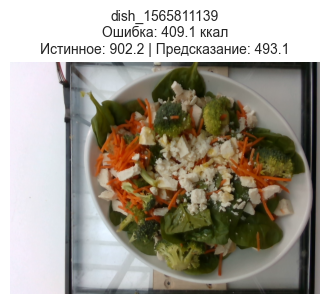

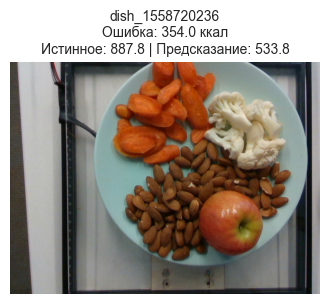

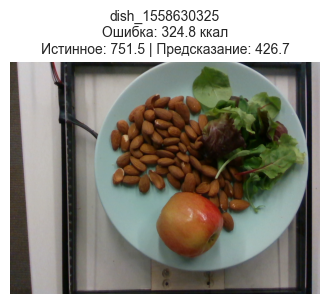

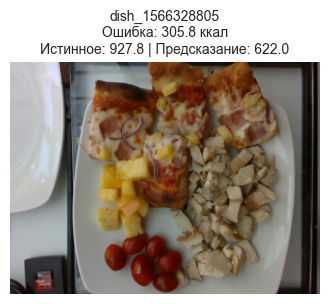

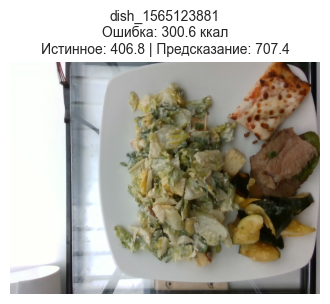

In [60]:

for i in top5_idx:
    dish_name = dish_names[i]
    dish_row = dish_df[dish_df['dish_id'] == dish_name].iloc[0]
    img_path = Path("data/images") / dish_name / "rgb.png"
    
    if img_path.exists():
        img = Image.open(img_path).convert("RGB")
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"{dish_name}\nОшибка: {errors[i]:.1f} ккал\nИстинное: {y_true[i]:.1f} | Предсказание: {y_pred[i]:.1f}",
            fontsize=10
        )
        plt.show()
    else:
        print(f"Изображение не найдено: {img_path}")

## Анализ топ-5 блюд с наибольшей ошибкой предсказания

| Блюдо | Истинное значение (ккал) | Предсказание (ккал) | Ошибка (ккал) | Возможные причины |
|-------|---------------------------|----------------------|----------------|-------------------|
| **dish_1565811139** | 902.2 | 493.1 | **409.1** | Салат с множеством мелких ингредиентов (овощи, фета, зелень). Модель могла недооценить калорийность из-за визуального сходства с «лёгкими» блюдами. |
| **dish_1558720236** | 887.8 | 533.8 | **354.0** | Смесь орехов, яблока и овощей — визуально простое блюдо, но высокая калорийность орехов не отражается в цвете/текстуре. Модель недооценила вклад орехов. |
| **dish_1558630325** | 751.5 | 426.7 | **324.8** | Аналогично предыдущему — орехи занимают большую часть тарелки, но имеют нейтральную текстуру и цвет. Вероятно, недостаточно примеров с орехами в обучающем наборе. |
| **dish_1566328805** | 927.8 | 622.0 | **305.8** | Комбинация пиццы, мяса и фруктов. Модель могла переоценить долю овощей/фруктов и недооценить пиццу. Возможна путаница при разделении областей блюда (разные продукты на одной тарелке). |
| **dish_1565123881** | 406.8 | 707.4 | **300.6** | Переоценка калорийности: возможно, кремовый или светлый соус на блюде был интерпретирован как жирный соус. Также могло повлиять некорректное центрирование при обрезке изображения. |

---

### Возможные причины ошибок в целом

1. **Нехватка разнообразных примеров**  
   Некоторые типы блюд (например, орехи или смешанные блюда с несколькими компонентами) могли встречаться редко в обучающем наборе, что снизило способность модели к обобщению.

2. **Ошибки из-за трансформаций при обучении**  
   При обучении применялись:
   - `A.RandomCrop` — случайное обрезание изображения, что могло удалять важные части блюда (например, более калорийные компоненты).  
   - `A.CoarseDropout` (вероятность 0.1, 1–2 отверстия) — мог частично «маскировать» куски блюда, уменьшая информативность для модели.  
   - `A.ColorJitter` — изменял насыщенность и контраст, что могло повлиять на восприятие цвета (например, отличить сыр от овощей).  

   В совокупности это могло в отдельных случаях привести к снижению точности, особенно на сложных композициях блюд.

3. **Сложность мультимодальной задачи**  
   Ошибка могла возникать из-за того, что текстовое описание ингредиентов не полностью совпадало с изображением (например, блюдо с недостающими или заменёнными ингредиентами).

4. **Ограниченность угла обзора**  
   На некоторых изображениях еда представлена под углом, из-за чего часть блюда скрыта — это снижает качество визуальных признаков.

---

Несмотря на эти локальные ошибки, **средний MAE составил 33.35 ккал**, что является довольно хорошим результатом для мультимодели, обученной на ограниченном датасете.


Использование **TTA (Test Time Augmentation)** позволило снизить ошибку MAE на ~3% по сравнению с базовой моделью.
